# Load Image Data and Training

## Inicialization and hyperparameter definition

In [2]:
import torch
from torch import nn, optim

from torchvision import datasets
from torchvision import transforms 

from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np
import time

args = {
    'batch_size': 5,
    'num_workers': 4,
    'num_classes': 10,
    'lr': 1e-4,
    'weight_decay': 5e-4,
    'num_epochs': 30
}

if torch.cuda.is_available():
  args['device'] = torch.device('cuda')
else:
  args['device'] = torch.device('cpu')

print(args['device'])

cpu


## Pytorch Datasets

* Torchtext: https://torchtext.readthedocs.io/en/latest/datasets.html
* Torchvision: https://pytorch.org/docs/stable/torchvision/datasets.html

### Torchvision datasets
``` python 
from torchvision import datasets 
data = datasets.MNIST(root, train=True, transform=None, target_transform=None, download=False)
```

Doc: https://pytorch.org/docs/stable/torchvision/datasets.html

### Torchvision transforms

Transforming images in tensors in order to be able to feed it into the network.
``` python 
from torchvision import transforms 
transforms.ToTensor() 
```

Doc: https://pytorch.org/docs/stable/torchvision/transforms.html

In [3]:
# Loading the dataset

train_set = datasets.MNIST('./', 
                           train=True, # Define as a training dataset
                           transform=transforms.ToTensor(), # Transforma a imagem em um tensor
                           download=True) # Downloads the dataset

test_set = datasets.MNIST('./', 
                           train=False, 
                           transform=transforms.ToTensor(),
                           download=False)

print('Train Set: ' + str(len(train_set)) + '\nTest Set:' + str(len(test_set)))

Train Set: 60000
Test Set:10000


## Checking train_set data

In [10]:
print(type(train_set))
print(type(train_set[0]))
print(f"Tensor dimensions {len(train_set[0][0][0])} X {len(train_set[0][0][0][0])}")
print(f"Image label: {train_set[0][1]}")

<class 'torchvision.datasets.mnist.MNIST'>
<class 'tuple'>
Tensor dimensions 28 X 28
Image label: 5


Podemos então iterar no dataset para observar algumas amostras e seus rótulos.

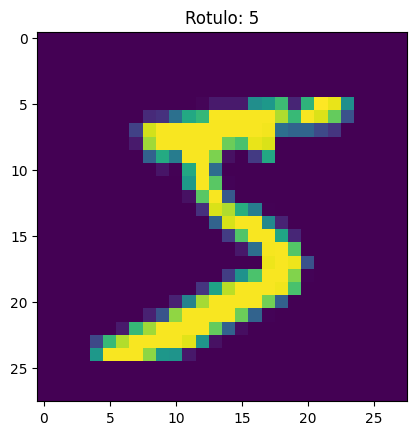

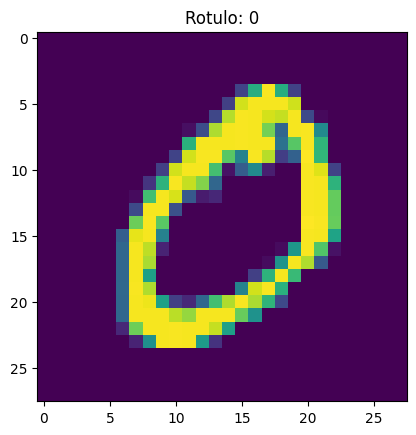

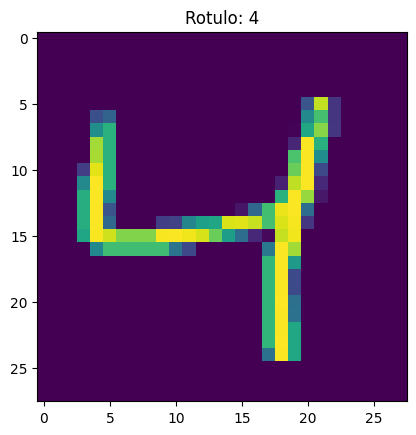

In [14]:
for i in range(3):
  dado, rotulo = train_set[i]

  plt.figure()
  plt.imshow(dado[0])
  plt.title('Rotulo: '+ str(rotulo))

Dataset class from Pytorch only load the data to the memory when needed. We can see that when update the transform function to RandomCrop(N), that takes a random NxN pixels part of the image. Each time we acess the same data we will see a new part of the data.

```python
transforms.RandomCrop(12)
```

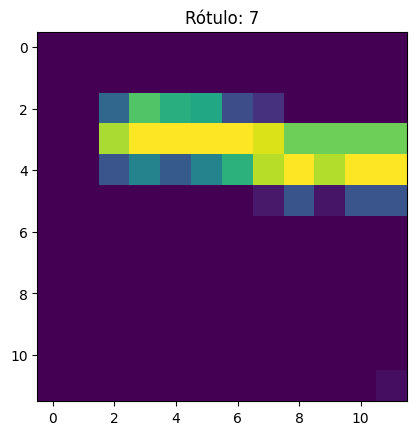

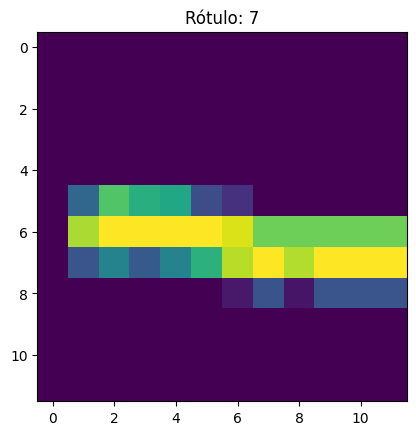

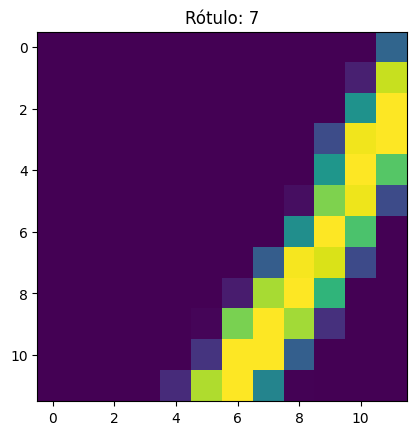

In [15]:
crop_set = datasets.MNIST('./', 
                           train=False, 
                           transform=transforms.RandomCrop(12),
                           download=False)

# Tuple (dado, rótulo)
for i in range(3):
  dado, rotulo = crop_set[0]
  
  plt.figure()
  plt.imshow(dado)
  plt.title('Rótulo: '+ str(rotulo))

## Dataloader

DataLoader from Pytorch manages the data loading process during our training.
* Split data into batches
* Mix up data
* Loads batches in pararel using threads

This funcionalities are on the following parameters:
```python
loader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=4)
```


In [16]:
train_loader = DataLoader(train_set, 
                          batch_size=args['batch_size'], 
                          shuffle=True, 
                          num_workers=args['num_workers'])

test_loader = DataLoader(test_set, 
                          batch_size=args['batch_size'], 
                          shuffle=True, 
                          num_workers=args['num_workers'])

The returned obj can be iterable but can't be index.

torch.Size([5, 1, 28, 28]) torch.Size([5])


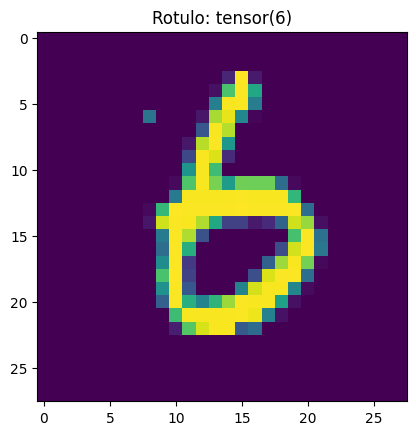

In [17]:
for batch in train_loader:
  
  dado, rotulo = batch
  print(dado.size(), rotulo.size())

  plt.imshow(dado[0][0])
  plt.title('Rotulo: '+ str(rotulo[0]) )
  break

## Creating the MLP

In [18]:
class MLP(nn.Module):

  def __init__(self, input_size, hidden_size, out_size):
    super(MLP, self).__init__()

    # Two hidden layers
    self.features  = nn.Sequential(
                      nn.Linear(input_size, hidden_size),
                      nn.ReLU(),
                      nn.Linear(hidden_size, hidden_size),
                      nn.ReLU()
                    )
    self.out     = nn.Linear(hidden_size, out_size)
    self.softmax = nn.Softmax() # Softmax activation function for multi-class classification

  def forward(self, X):
    X = X.view(X.size(0), -1) # Flatten the input tensor
    feature = self.features(X) # Extract features
    output  = self.softmax(self.out(feature)) # Classify the features
    return output

input_size  = 28 * 28
hidden_size = 128
out_size    = 10 #classes

torch.manual_seed(42)
net = MLP(input_size, hidden_size, out_size).to(args['device']) #cast na GPU 

## Loss and Optim 

In [19]:
criterion = nn.CrossEntropyLoss().to(args['device'])
optimizer = optim.Adam(net.parameters(), lr=args['lr'], weight_decay=args['weight_decay']) # weight_decay helps to prevent overfitting

# Training Flow

In [10]:
for epoch in range(args['num_epochs']):
  start = time.time()

  epoch_loss = []
  for batch in train_loader:
    
    dado, rotulo = batch

    # Cast na GPU
    dado   = dado.to(args['device'])
    rotulo = rotulo.to(args['device'])

    # Forward 
    pred = net(dado)
    loss = criterion(pred, rotulo)
    epoch_loss.append(loss.cpu().data)

    # Backward
    loss.backward()
    optimizer.step()

  epoch_loss = np.asarray(epoch_loss)
  end = time.time()

  print("Epoch %d, Loss: %.4f +\- %.4f, Time: %.2f" % (epoch, epoch_loss.mean(), epoch_loss.std(), end-start) )


/Users/math/Documents/Times/repos/NeuralNetworkEssentials/venv/lib/python3.10/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoca 0, Loss: 1.9499 +\- 0.2454, Tempo: 51.10
Epoca 1, Loss: 2.0299 +\- 0.2242, Tempo: 46.02
Epoca 2, Loss: 2.1766 +\- 0.2125, Tempo: 46.97
Epoca 3, Loss: 2.1733 +\- 0.2009, Tempo: 46.46
Epoca 4, Loss: 2.1639 +\- 0.2052, Tempo: 47.17
Epoca 5, Loss: 2.1667 +\- 0.2049, Tempo: 50.37
Epoca 6, Loss: 2.1715 +\- 0.2024, Tempo: 51.22


KeyboardInterrupt: 

### Model Quality

Acurracy score can help check the model quality.
```python
metrics.accuracy_score(rotulos, ypreds)
```

Doc: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html